In [6]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models
import pandas as pd
import os
import pydicom
import numpy as np
import h5py
import time
from tqdm import tqdm as tqdm
import cv2
import pickle
from shutil import copyfile
from matplotlib import pyplot as plt
import seaborn as sns
import random
from torch import nn
from torch.autograd import Variable

In [2]:
class StudyLevelDataset2(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, stage):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        
        #self.hdf5_filename = '/scratch/features.hdf5'
        self.hdf5_filename1 = '/scratch/efficientb0_features.hdf5'
        self.hdf5_filename2 = '/scratch/resnet_features.hdf5'
        
        self._generate_row_indices_list()
        
        self.stage = stage
        
        if self.stage == 'train':
            self.start = 0
            self.end = 2650
        else:
            self.start = 2660
            self.end = 3500
        
        # 0 - 2650 train
        # 2660 - 3500 valid

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        #return len(self.pedataframe)
        return self.end - self.start + 1
        #return num_pos_samples_per_dataset + num_neg_samples_per_dataset
        
    def _generate_row_indices_list(self):
        # group slice indices into studies
        self.row_indices = [] # index into train df for every study
        current_study_id = ''

        for slice_index in range(len(self.pedataframe)):
            new_study_id = self.pedataframe.StudyInstanceUID[slice_index]
            if new_study_id != current_study_id:
                self.row_indices.append(slice_index)
                current_study_id = new_study_id
            if slice_index % 100000 == 0:
                print(slice_index)
        
    def __getitem__(self, study_index):
        '''  '''
        study_index = study_index + self.start
        
        #h5py_file = h5py.File(self.hdf5_filename, "r")
        h5py_file1 = h5py.File(self.hdf5_filename1, "r")
        h5py_file2 = h5py.File(self.hdf5_filename2, "r")
        
        start_index = self.row_indices[study_index]
        if study_index+1 < len(self.row_indices):
            stop_index = self.row_indices[study_index+1]
        else:
            stop_index = len(self.pedataframe)
            
        # dim: seq_len x embedding_dim
        x = np.ones((stop_index-start_index, 3328)) #1280+2048=3328
            
        for slice_index in range(start_index, stop_index):
            data_identifier = 'tensor(' + str(slice_index) + ')'
            #slice_embeddings = h5py_file[data_identifier][:]
            slice_embeddings = np.concatenate((h5py_file1[data_identifier][:], h5py_file2[data_identifier][:]),axis=0)
            x[slice_index-start_index,:] = slice_embeddings

            
        y = np.ones(9)
            
        y[0] =  self.pedataframe.negative_exam_for_pe[start_index]
        y[1] = self.pedataframe.rv_lv_ratio_gte_1[start_index]
        y[2] = self.pedataframe.rv_lv_ratio_lt_1[start_index]
        y[3] = self.pedataframe.leftsided_pe[start_index]
        y[4] = self.pedataframe.chronic_pe[start_index]
        y[5] = self.pedataframe.rightsided_pe[start_index]
        y[6] = self.pedataframe.acute_and_chronic_pe[start_index]
        y[7] = self.pedataframe.central_pe[start_index]
        y[8] = self.pedataframe.indeterminate[start_index]
        
        h5py_file1.close()
        h5py_file2.close()
        
        return x, y

In [3]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'
valid_dataset = StudyLevelDataset2(csv_file=train_csv, stage='valid')

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [4]:
'''
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
'''

batch_size = 1
embedding_dim = 3328  #2048+1280=3328
nb_lstm_units = 64 #2048

class StudyLevelLSTM(nn.Module):
    def __init__(self, nb_layers=1, nb_lstm_units=nb_lstm_units, 
                 embedding_dim=embedding_dim, batch_size=batch_size):
        
        super(StudyLevelLSTM, self).__init__()

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True
        )

        # output layer
        self.linear = nn.Linear(self.nb_lstm_units, 9)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_h0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_c0 = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)

        hidden_h0 = hidden_h0.to(device)
        hidden_c0 = hidden_c0.to(device)

        hidden_h0 = Variable(hidden_h0)
        hidden_c0 = Variable(hidden_c0)

        return (hidden_h0.to(device), hidden_c0.to(device))
    
    def forward(self, X):
        # reset the LSTM hidden state. Must be done before you run a new batch. Otherwise the LSTM will treat
        # a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()

        batch_size, seq_len, _ = X.size()

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        #X = torch.nn.utils.rnn.pack_padded_sequence(x, X_lengths, batch_first=True)

        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        
        X = self.hidden[0]
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.linear(X)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, 9)

        return X

In [5]:
# sanity test

model = StudyLevelLSTM()
print(model)
device = 'cpu'
model.to(device)
x,y = valid_dataset[1]
x = torch.tensor(x)
x = x.unsqueeze(0).float()
x = x.to(device)

pred = model(x)
print(pred)
print(y)

StudyLevelLSTM(
  (lstm): LSTM(3328, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=9, bias=True)
)
tensor([[-0.0022, -0.0719,  0.0219,  0.0468, -0.0612,  0.1055,  0.0932, -0.1219,
          0.1798]], grad_fn=<ViewBackward>)
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
model.load_state_dict(torch.load('/projectnb/ece601/kaggle-pulmonary-embolism/jiamingy/combined_Sequencemodel/model-combined-lstm2.pth'))

<All keys matched successfully>

In [9]:
pred = model(x)
print(pred)
print(y)

tensor([[ 1.2457, -3.3858, -1.7025, -2.8502, -3.2523, -1.8759, -4.5232, -4.4451,
         -3.2315]], grad_fn=<ViewBackward>)
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
def test(model, loader):
    model.eval()
    val_loss = []
    pos_probs = []
    neg_probs = []
    y_test = []
    y_score = []
    
    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data.float())


            logits = logits.squeeze()
            target = target.squeeze()
            
            probs = torch.sigmoid(logits)
            
            i = 0 # index of PE prediction
            b = target[i].detach().cpu().numpy()
            if b == 1:
                pos_probs.append(float(probs[i].detach().cpu().numpy()))
            else:
                neg_probs.append(float(probs[i].detach().cpu().numpy()))
                
            y_score.append(probs[i].detach().cpu().numpy())
            y_test.append(b)
    
    return pos_probs, neg_probs, y_score, y_test

In [21]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,num_workers=1)

#"test"
pos_probs, neg_probs, y_score, y_test = test(model, valid_loader)

100%|██████████| 841/841 [02:12<00:00,  6.34it/s]


In [22]:
FN = 0
FP = 0
TN = 0
TP = 0

for p in pos_probs:
    if p > 0.5:
        TP += 1
    else:
        FN += 1

for p in neg_probs:
    if p > 0.5:
        FP += 1
    else:
        TN += 1
        
print("FP: ", FP, " TP: ", TP, "FN: ", FN, "TN: ", TN)

FP:  86  TP:  518 FN:  87 TN:  150


ROC Curve
---------

*Caveat*: validation samples were never seen by the LSTM. The negative slices in the validation data were never seen by either CNNs or LSTM. However, all the positive slices in the validation data were seen by the CNN during training.

In [2]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [4]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

n_classes = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr[0], tpr[0], _ = roc_curve(pe_label, pred)
roc_auc[0] = auc(fpr[0], tpr[0])


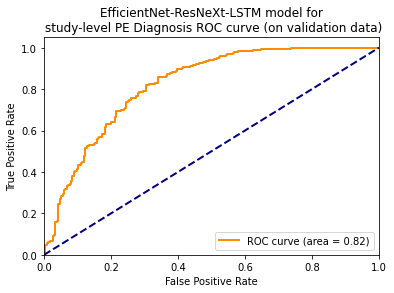

In [8]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNet-ResNeXt-LSTM model for\n study-level PE Diagnosis ROC curve (on validation data)')
plt.legend(loc="lower right")
plt.show()

In [41]:
import pickle

with open('pe_label.pkl', 'wb') as f:
    pickle.dump(y_test, f)

with open('pred.pkl', 'wb') as f:
    pickle.dump(y_score, f)


In [1]:
import pickle
with open('pe_label.pkl', 'rb') as f:
    pe_label = pickle.load(f)

with open('pred.pkl', 'rb') as f:
    pred = pickle.load(f)

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

In [7]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(classifier, pred, pe_label,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 #normalize=normalize
                                )
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

NameError: name 'classifier' is not defined